In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import numpy as np
import tensorflow as tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
#from tensorflow.keras.applications.vgg16 import preprocess_input 
#from tensorflow.keras.applications.resnet_v2 import preprocess_input
#from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from time import time
from keras.callbacks import TensorBoard
from keras import backend as K

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/drive/MyDrive/Colab Notebooks/498R/Mask Detector/ALL_DATASETS/dataset'))
data = []
labels = []

[INFO] loading images...


In [ ]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/498R/Mask Detector/training_labels.csv')

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# # construct the head of the model that will be placed on top of the
# # the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(2, activation="softmax")(headModel)

#SVM Classifier
headModel = Dense(1, activation="linear",kernel_regularizer=l2(0.01))(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# model = VGG16(weights=None, include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
# baseModel = InceptionV3(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))
# baseModel.output_shape

87916544/87910968 [==============================] - 0s 0us/step


(None, 5, 5, 2048)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss="hinge", optimizer='adadelta',metrics=['acc',f1_m,precision_m, recall_m])

tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/498R/Mask Detector/logs/{}'.format(time()))

history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
  callbacks=[tensorboard])

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['acc',f1_m,precision_m, recall_m])

tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/498R/Mask Detector/logs/{}'.format(time()))

# train the head of the network
print("[INFO] training head...")
history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
  callbacks=[tensorboard])

In [ ]:
import tensorflow as tf
import pathlib 

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
export_dir = '/content/'
#tf.saved_model.save(model, export_dir)
model.save("mobilenetv2.h5", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.55      0.98      0.70       384
without_mask       0.91      0.19      0.32       386

    accuracy                           0.59       770
   macro avg       0.73      0.59      0.51       770
weighted avg       0.73      0.59      0.51       770

[INFO] saving mask detector model...


In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(testX, testY, verbose=0)

## Converting to tflite 

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/mask_detector.tflite')
tflite_model_file.write_bytes(tflite_model)

9544552

## Evaluation

KeyError: ignored

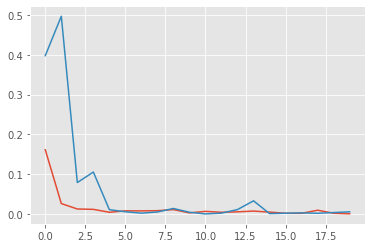

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])